In [1]:
import subprocess
import os
import shutil
import json
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import wandb

# Entraînement du model

## Génération des fichiers .spacy à partir des fichiers JSON

In [2]:
!python scripts/convert.py fr assets/train.json corpus/train.spacy 1
!python scripts/convert.py fr assets/dev.json corpus/dev.spacy 1
!python scripts/convert.py fr assets/test.json corpus/test.spacy 1


Map: 100%|██████████| 11492/11492 [00:07<00:00, 1455.65 examples/s]

Map: 100%|██████████| 11492/11492 [00:06<00:00, 1826.52 examples/s]

Map: 100%|██████████| 2695/2695 [00:00<00:00, 3492.96 examples/s]

Map: 100%|██████████| 2695/2695 [00:00<00:00, 4630.93 examples/s]

Map: 100%|██████████| 2804/2804 [00:01<00:00, 2246.96 examples/s]

Map: 100%|██████████| 2804/2804 [00:00<00:00, 3187.88 examples/s]


In [2]:
!python -m spacy init fill-config configs/base_config.cfg configs/config.cfg

✔ Auto-filled config with all values
✔ Saved config
configs\config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


à modifier dans le fichier généré:<br>
[training.logger]<br>
@loggers = "spacy.WandbLogger.v3"<br>
project_name = "my_spacy_project"<br>
remove_config_values = ["paths.train", "paths.dev", "corpora.train.path", "corpora.dev.path"]<br>
log_dataset_dir = "./corpus"<br>
model_log_interval = 200<br>

In [3]:
wandb.login(key= "8d6dd5c5f51d00fe03c0eba2990860cd9402d573")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marcotte-mickael (mam14). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\utilisateur\.netrc


True

In [4]:
def renommer_dossier(nom_dossier_a_modifier, dossier_ref):  
    try:        
        nb_dans_dossier_ref = len(os.listdir(dossier_ref))
        nouveau_nom_dossier = f'{nom_dossier_a_modifier}_{nb_dans_dossier_ref + 1}' 
        os.rename(nom_dossier_a_modifier, nouveau_nom_dossier)
        
        print(f"Dossier '{nom_dossier_a_modifier}' a été renommé en '{nouveau_nom_dossier}' avec succès.")

        return nouveau_nom_dossier
    except Exception as e:
        print(f"Une erreur s'est produite lors du renommage du dossier : {e}")

def deplacer_dossier(source, destination):    
    try:
        source_nom_modifie = renommer_dossier(source, destination)
        print('source nom modifie', source_nom_modifie)
        shutil.move(source_nom_modifie, destination)
        print(f"Dossier déplacé de '{source}' vers '{destination}' avec succès.")
    except Exception as e:
        print(f"Une erreur s'est produite lors du déplacement du dossier : {e}")

## Entrainement et validation

      # --training.eval_frequency 10 --training.patience 50 --gpu-id ${vars.gpu_id} --initialize.vectors ${vars.vectors_model} --components.tok2vec.model.embed.include_static_vectors true"


In [5]:
source = r'E:\training'
destination = r'E:\versioning'

# déplace le dossier training précédent dans le dossier training_save, car il doit être effacé pour relancer le modèle.
deplacer_dossier(source, destination)

# Récupère les données générées par la commande !spacy project run train
process = subprocess.Popen(["spacy", "project", "run", "train"], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True, encoding='utf-8')

for line in process.stdout:
    line = line.rstrip()
    print(line)

# Fermez le processus
process.communicate()

Une erreur s'est produite lors du renommage du dossier : [WinError 3] Le chemin d’accès spécifié est introuvable: 'E:\\training\\versioning'
source nom modifie None
Une erreur s'est produite lors du déplacement du dossier : rename: src should be string, bytes or os.PathLike, not NoneType

=================================== train ===================================
Running command: 'C:\PCO\.venv\Scripts\python.exe' -m spacy train configs/config.cfg --output E:/training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy
ℹ Saving to output directory: E:\training
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE
---  ------  ------------  --------  ------  ------  ------  ------
wandb: Currently logged in as: mar

('', None)

## Evaluation du modèle.

In [5]:
def lecture_fichier_json(nom_fichier:str):
    try:
        with open(nom_fichier, 'r') as fichier:
            json_file = json.load(fichier)
            return json_file
    except Exception as e:
        print(f"Une erreur s'est produite lors de la lecture du fichier JSON : {e}")
        return None

def ajout_metrics_df(df, metrics:dict):
    df.loc[len(df)] = metrics
    return df    

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.

In [6]:
!spacy project run evaluate


================================== evaluate ==================================
Running command: 'C:\PCO\.venv\Scripts\python.exe' -m spacy evaluate training/model-best corpus/test.spacy --output training/metrics.json
ℹ Using CPU

================================== Results ==================================

TOK     -    
NER P   89.11
NER R   79.99
NER F   84.31
SPEED   2099 


=============================== NER (per type) ===============================

           P       R       F
DIAG   89.11   79.99   84.31

✔ Saved results to training\metrics.json


In [8]:
def insert_into(essai, taille_train, taille_valid, remarque, hyperparametre, 
                ents_precision, ents_rappel, ents_scoref1,speed):
    dtypes = {
        'essai':str,
        'taille_train':int,
        'taille_valid':int,
        'remarque':str,
        'hyperparametre':str,
        'ents_precision':float,
        'ents_rappel':float,
        'ents_score_f1':float,
        'speed':float
    }
    metrics_df = pd.read_csv('G:/Mon Drive/PCO/data/metrics.csv', sep=';', dtype=dtypes)
    new_datas = pd.Series({
        'train':essai,
        'taille_train':taille_train,
        'taille_valid':taille_valid,
        'remarque':remarque,
        'hyperparametre':hyperparametre,
        'ents_precision':ents_precision,
        'ents_rappel':ents_rappel,
        'ents_score_f1':ents_scoref1,
        'speed': speed
    })
    new_metrics_df = pd.concat([metrics_df, new_datas.to_frame().T], ignore_index=True)
    new_metrics_df.to_csv('G:/Mon Drive/PCO/data/metrics.csv', sep=';', index=False)

In [9]:
json_metric = r'C:\PCO\generate_model\training\metrics.json'
metrics = lecture_fichier_json(json_metric)

with open('assets/train.json', 'r', encoding='utf-8') as fichier:
    # Charger les données JSON depuis le fichier
    train_json = json.load(fichier)

with open('assets/dev.json', 'r', encoding='utf-8') as fichier:
    # Charger les données JSON depuis le fichier
    valid_json = json.load(fichier)


essai = 'Train 7'
remarque = 'pipeline cpu "accuracy"'
taille_train = len(train_json)
taille_valid = len(valid_json)
hyperparameters = ''


insert_into(essai, taille_train, taille_valid, remarque, hyperparameters,
            metrics['ents_p'], metrics['ents_r'],  metrics['ents_f'], metrics['speed'])

OSError: [Errno 22] Invalid argument

In [17]:
nlp = spacy.load(r"C:\PCO\generate_model\training\model-best")

text = f"""
Sur la base de ces observations, nous concluons que cette biopsie révèle une gastroentérite. Cette maladie chronique peut être associée à des symptômes tels que douleurs abdominales, diarrhée sanglante et perte de poids. Des suivis réguliers et un traitement adéquat sont recommandés pour contrôler l'inflammation intestinale et prévenir les complications potentielles telles que la sténose intestinale, les fistules et la formation de granulomes.
"""
doc = nlp(text)

for ent in doc.ents:
    print(ent.text, ent.label_)
    # print(spacy.explain(ent.label_))

gastroentérite DIAG


In [11]:
def predict_test(): 
    nlp = spacy.load(r"C:\PCO\generate_model\training\model-best")
    test = r'C:\PCO\generate_model\assets\test.json'

    with open(test, 'r', encoding='utf-8') as fichier:
        json_test = json.load(fichier)

    diag_true = []
    diag_predict = []

    for test in json_test:
        conclusion = test[0]
        diagnostic_true = conclusion[test[1]['entities'][0][0]: test[1]['entities'][0][1]]
        diag_true.append([diagnostic_true])
        
        doc = nlp(conclusion)
        predict = []
        if len(doc.ents) != 0: 
            for ent in doc.ents:
                if ent.text is not None:
                    predict.append(ent.text)
                else:
                    predict.append("")        
        else:
            predict.append('')
        diag_predict.append(predict)
    return diag_true, diag_predict

def generate_confusion_matrix (diag_true, diag_predict):
    response_predict = []
    response_true = []

    for index, diag in enumerate(diag_true): 
        for diag_pred in diag_predict[index]:
            if diag[0] == diag_pred:
                # le diagnostic attendu correspond à la prédiction
                response_true.append(1)
                response_predict.append(1)        
            elif diag_pred == '':
                # pas de prédiction
                response_true.append(1)
                response_predict.append(0)
            elif diag[0] != diag_pred:            
                # présence d'une prédiction alors qu'il n'y a pas de diagnostic attendu
                response_true.append(0)
                response_predict.append(1)


    conf_matrix = confusion_matrix(response_predict, response_true)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=[0, 1],
                        yticklabels=[0, 1])
    plt.xlabel('Vraies étiquettes')
    plt.ylabel('Prédictions')
    plt.title(f'Matrice de Confusion')
    plt.show()

def camembert_aug_conf_matrix (diag_true, diag_predict):
    response_0 = 0
    response_1 = 0
    response_2 = 0
    response_3 = 0
    response_4 = 0

    partiellement_moins = []
    partiellement_plus = []
    pas_trouve = []

    # diag_predict[3] = ['eczéma nummulaire', 'carcinome basocellulaire']

    for index, diag in enumerate(diag_true): 
        for diag_pred in diag_predict[index]:
            if diag[0] == diag_pred:
                response_1 += 1
                # le diagnostic attendu correspond à la prédiction    
            elif diag_pred == '':
                # pas de prédiction
                response_0 += 1
                pas_trouve += [diag[0]]
            elif diag[0] != diag_pred:  
                if diag[0] in diag_pred:          
                    # présence d'une prédiction alors qu'il n'y a pas de diagnostic attendu
                    partiellement_plus.append([diag_pred, diag[0]])
                    response_2 += 1
                elif diag_pred in diag[0]:
                    partiellement_moins.append([diag_pred, diag[0]])
                    response_3 += 1
                elif diag[0] not in diag_pred and diag_pred not in diag[0]:
                    response_4 += 1
    response = [response_0, response_1, response_2, response_3, response_4]
    labels = ['Pas trouvé', 'Exactement', 'Plus', 'Partiellement', 'Différent']

    # Configuration de Seaborn
    sns.set(style="whitegrid")

    for index, resp in enumerate(response):
        if resp == 0:
            response.pop(index)
            labels.pop(index)

    # Création du camembert avec un trou au centre
    plt.figure(figsize=(6, 6))
    plt.pie(response, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"), wedgeprops=dict(width=0.4, edgecolor='w'))

    # Ajout d'un cercle blanc au centre pour créer le trou
    centre_circle = plt.Circle((0,0),0.2,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Ajustements
    plt.axis('equal')
    plt.title('')
    plt.show()

    return partiellement_moins, partiellement_plus, pas_trouve

In [12]:
diag_true, diag_predict = predict_test()

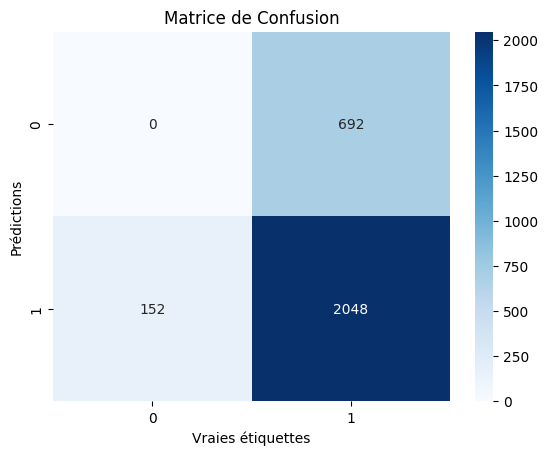

In [13]:
generate_confusion_matrix(diag_true, diag_predict)

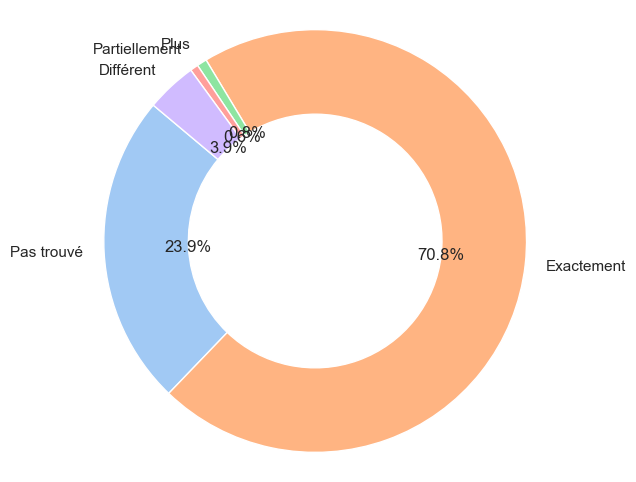

In [14]:
partiellement_moins, partiellement_plus, pas_trouve = camembert_aug_conf_matrix (diag_true, diag_predict)

In [15]:
pas_trouve

['glomangiomatose',
 'cystadénome',
 'tumeur carcinoïde',
 'glomangiomatose',
 'gastroparésie',
 'thrombocytémie essentielle',
 'discopathie',
 'pancreatite',
 'mucocele appendiculaire',
 'tumeur neuroendocrine',
 'pancreatite',
 'hémangioendothéliome Kaposiforme',
 'discopathie',
 'camptocormie',
 'pancreatite',
 'tumeur neuroendocrine',
 'thrombocytémie essentielle',
 'gastroparésie',
 'tumeur carcinoïde',
 'tumeur carcinoïde',
 'hyperbilirubinémie',
 'hyperbilirubinémie',
 'thrombocytémie essentielle',
 'camptocormie',
 'gastroparésie',
 'albinisme',
 'tumeur carcinoïde',
 'cancer indifférencié',
 'galactosémie',
 'posthite',
 'galactosémie',
 'cystadénome',
 'discopathie',
 'glycogénose',
 'pancreatite',
 'exostose',
 'posthite',
 'hypothyroïdie',
 'exostose',
 'glycogénose',
 'thrombocytémie essentielle',
 'pancreatite',
 'tumeur neuroendocrine',
 'tumeur carcinoïde',
 'gastroparésie',
 'exostose',
 'albinisme',
 'galactosémie',
 'tumeur vitelline',
 'exostose',
 'pancreatite',
 '